# <font color=black> Spinal cord networks: Functional connectivity </font>
<hr style="border:1px solid black">

### Imports

In [1]:
import sys,json
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns
import os
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr



main_dir='/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project/'
sys.path.append(main_dir+'/code/')
config_file=main_dir + '/config/analyses/brsc_functional.json'
config_file2=main_dir + '/config/preprocessing/01_brsc_preprocess_func.json'

from plotting import Plot_sc
from plotting import Plotting

import brsc_utils as utils
#from connectivity.post_icaps import post_icaps
from connectivity.seed_to_target import Seed2target
from brsc_statistics import Statistics 
%matplotlib inline
%load_ext autoreload
%autoreload 2

### load config file
with open(config_file) as config_f:
    config = json.load(config_f) # load config info

with open(config_file2) as config_f:
    config_proc = json.load(config_f) # load config info
stat_func=Statistics(config=config,ana_dir="",analysis="")

<hr style="border:1px solid black">

### <font color=#04AF98> A SPINAL CORD functional connectivity 
##### Initialize the analysis

In [2]:
structure="spinalcord"


seed2seed=Seed2target(config_file,IDs=config["participants_IDs_ALL"],kind="corr",seed_kind="atlas",structure=[structure]) # initialize the function
ouputdir=config['project_dir'] + config["seed2seed"]['analysis_dir'][structure] 
plot=Plotting(config_file,ouputdir)


redo_indiv=True # rerun first level

Your are going to run seed2seed analysis here:
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/preprint2025/seed2seed/spinalcord/

Seeds are located within the spinalcord structure

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//templates/PAM50/atlas/Frostell_28Parcels_7Networks/Frostell_28Parcels_7Networks.txt
spinalcord atlas info: Frostell_28Parcels_7Networks.txt


Start the analysis on: 67 participants


#### <font color=#04AF98> B.2 Timeseries extraction

In [3]:
timeseries,timeseries_labels,labels_list=seed2seed.extract_atlas_data(standardize='zscore',redo=False,n_jobs=3)

The timeseries were already extracted, loading them ...


#### <font color=#04AF98> B.3 Correlation analysis

In [4]:
#concatenante brain and spinal cord array
timeseries_zmean=[];labels_concat=[]

results = []
output_dir={};output_file={};

corr_concat_df,corr_half_concat_df,corr_mean_df =seed2seed.correlation_df(timeseries_labels,
                                                     timeseries_labels,
                                                    tag= "_C1C7_quad_z",
                                                         groups=["ALL",'YA','MA','OA'],
                                                         labels=True,
                                                      #partial_ts=timeseries_csf,
                                                         redo=False, n_jobs=1)



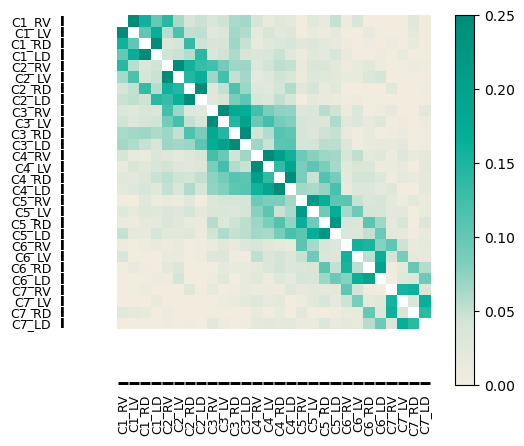

In [9]:
output_dir=config["project_dir"] +  "/figures/f02_functional_sc/preprint2025/seed2seed/spinalcord/"
colors = ["#F2ECDF","#D5E5D7","#7BCEBC","#40BFAA","#04AF98","#029E89","#008C79"]  # green

custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
for group in ["ALL"]:#,"YA","MA","OA"]:
    mean_matrix=corr_concat_df[group].groupby(["seed1", "seed2"], sort=False)[["fcorr"]].mean().reset_index()
    plot.plot_heatmap(matrix=corr_concat_df[group],
                  networks=labels_list,
                      vmax=0.25,vmin=0,
                      cmap=custom_cmap,
                      index_raw='seed1',index_col='seed2',metric='fcorr',
                      #labels=config["seeds"]["spinalcord"]["names"],
                  plot_networks=True,xlabels=True,ylabels=True,
                       output_f=output_dir + 'figures/FC_matrix.pdf',
                  #output_f=output_dir + '/figures/indiv/corr_matrix_' + ID + ".pdf",
                      save=False)
plt.show()

#### <font color=#04AF98> B.4 Intra vs Inter FC

t(66): 17.25 p-value: 3.782157674717799e-26


/export02/data/landelle/anaconda/envs/CL_brsc_aging_env_py10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


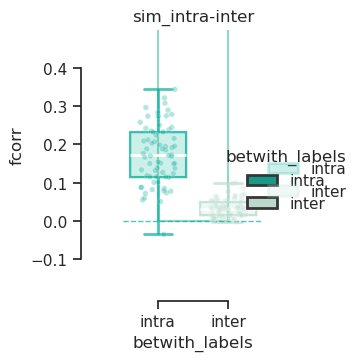

loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading
loading


In [10]:
from scipy import stats
mean_betwith=corr_half_concat_df['ALL'].groupby(["IDs","age","sex","betwith_labels"], sort=False)[["fcorr"]].mean().reset_index()
mean_betwith["betwith_labels"] = pd.Categorical(mean_betwith["betwith_labels"], categories=["intra", "inter"], ordered=True)
mean_betwith = mean_betwith.sort_values(by=["IDs", "age", "sex", "betwith_labels"]).reset_index(drop=True)


output_f=output_dir + '2_second_level/n67_betwith_fcorr.csv'
if not os.path.exists(output_f):
    mean_betwith.to_csv(output_f, index=False)


# ---- compute within versus between t-test
t_test=stats.ttest_rel(mean_betwith[mean_betwith["betwith_labels"]=="intra"]["fcorr"],mean_betwith[mean_betwith["betwith_labels"]=="inter"]["fcorr"])
print("t(" + str(t_test.df) + "): " + str(np.round(t_test.statistic,2)) + " p-value: " + str(t_test.pvalue))


plot.boxplots(df=mean_betwith,
              x_data="betwith_labels",x_order=["intra","inter"],
                  indiv_values=True,#invers_axes=True,
                  palette=["#04AF98","#B7DDCE"],#output_dir=config['main_dir'] + config['analysis_dir']['spinalcord'] + '/figures/',
                  #output_tag='corr_' + group_name,
              height=3,aspect=0.5,
                  y_data="fcorr",
              ymin=-0.1, ymax=0.5,
              output_dir=output_dir,
              output_tag="sim_intra-inter",
              save=False)
plt.show()

### <font color=#04AF98> Age effect

t: 0.85 p_val: 0.3928


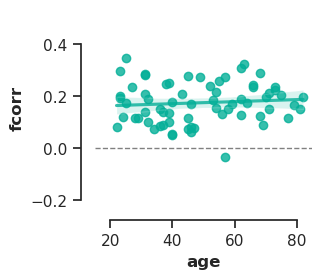

t: 2.93 p_val: 0.0033


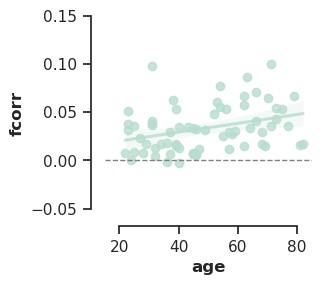

In [16]:
df=corr_half_concat_df["ALL"].groupby(["IDs","age","sex","betwith_labels"])["fcorr"].mean().reset_index()
df_intra=df[df["betwith_labels"]=="intra"]
df_inter=df[df["betwith_labels"]=="inter"]

signed_r2, p_age,p_sex, beta_age,beta_sex, stat_age,stat_sex=stat_func.signed_partial_r2(df=df_intra,y="fcorr",predictor="age",covariates=["sex"],random="IDs")
        
print("t: " + str(np.round(stat_age,2)) + " p_val: "+ str(np.round(p_age,4)))
plot.lmplots(df=df_intra,color=["#04AF98"],
                 x_data="age",
                 y_data="fcorr",xmin=15,xmax=85,
             indiv_values=True,
                 save=False)


signed_r2, p_age,p_sex, beta_age,beta_sex, stat_age,stat_sex=stat_func.signed_partial_r2(df=df_inter,y="fcorr",predictor="age",covariates=["sex"],random="IDs")
     
print("t: " + str(np.round(stat_age,2)) + " p_val: "+ str(np.round(p_age,4)))
plot.lmplots(df=df_inter,color=["#B7DDCE"],
                 x_data="age",
                 y_data="fcorr",xmin=15,xmax=85,
             indiv_values=True,
                 save=False)

inter


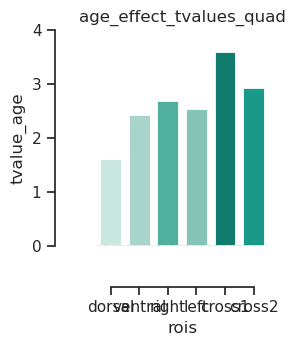

      rois signed_r2     p_age     p_sex  beta_age  beta_sex  tvalue_age  \
0   dorsal         _  0.104510  0.006689  0.000312 -0.017816    1.623373   
1  ventral         _  0.014722  0.211437  0.000469 -0.008210    2.439156   
2    right         _  0.006808  0.386215  0.000511 -0.005593    2.706111   
3     left         _  0.010536  0.401123  0.000500 -0.005615    2.557735   
4   cross1         _  0.000290  0.208619  0.000622 -0.007377    3.623910   
5   cross2         _  0.003207  0.056226  0.000562 -0.012459    2.947143   

   tvalue_sex  page_fdr  psex_fdr  
0   -2.711925  0.104510  0.040136  
1   -1.249625  0.017666  0.317155  
2   -0.866502  0.013615  0.401123  
3   -0.839617  0.015803  0.401123  
4   -1.257372  0.001741  0.317155  
5   -1.909277  0.009622  0.168679  
intra


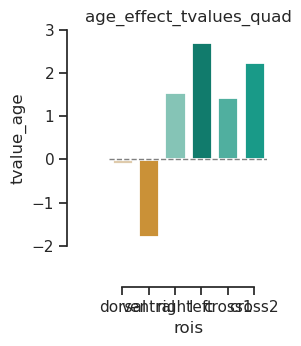

      rois signed_r2     p_age     p_sex  beta_age  beta_sex  tvalue_age  \
0   dorsal         _  0.920657  0.040535 -0.000088 -0.061589   -0.099607   
1  ventral         _  0.071952  0.000101 -0.001401 -0.103573   -1.799423   
2    right         _  0.115927  0.072552  0.000828 -0.032339    1.572103   
3     left         _  0.006544  0.018019  0.001471 -0.043758    2.719221   
4   cross1         _  0.149188  0.016999  0.000786 -0.044484    1.442405   
5   cross2         _  0.023210  0.006456  0.001087 -0.044615    2.269959   

   tvalue_sex  page_fdr  psex_fdr  
0   -2.048250  0.920657  0.048643  
1   -3.889145  0.143904  0.000604  
2   -1.795637  0.173890  0.072552  
3   -2.365221  0.039262  0.027029  
4   -2.386732  0.179026  0.027029  
5   -2.723679  0.069630  0.019368  


In [17]:
output_dir=config["main_dir"] +  "/figures/f02_functional_sc/seed2seed_nostd/spinalcord/"
#--- Global results
df_mean =corr_half_concat_df['ALL'].groupby(['IDs', 'group','age', 'sex'], as_index=False)['fcorr'].mean()
mean_results = [];
signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_mean,y="fcorr",predictor="age",covariates=["sex"])
mean_results.append({"rois":"mean","signed_r2": signed_r2_2,"p_age": p_age2,"p_sex": p_sex2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})

#--- Results by regions
param={"intra":{"y_lim":[-2,3],"colors":["#e7cda4","#E2971F","#7BCEBC","#008C79","#40BFAA","#04AF98"]},
      "inter":{"y_lim":[0,4],"colors":["#C4EBE2","#A0DDCF","#40BFAA","#7BCEBC","#008C79","#04AF98"] }}

for region in ["inter","intra"]:
    print(region); roi_results=[];
    df_reduced=corr_half_concat_df['ALL'][corr_half_concat_df['ALL']["betwith_labels"]==region]
    roi_results=[];
    for roi in ["dorsal","ventral","right","left","cross1","cross2"]:
        df_roi_metrics=df_reduced[(df_reduced["labels1"]==roi)].groupby(['IDs', 'age', 'sex',"seed1","seed2"], as_index=False)["fcorr"].mean()
        signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y="fcorr",predictor="age",covariates=["sex"],random="IDs")
        roi_results.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"p_sex": p_sex2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
    
    
    mean_result_df= pd.DataFrame(mean_results)  
    roi_results_df= pd.DataFrame(roi_results)
    
    
    plot.barplots(df=roi_results_df, x_data="rois",x_order=["dorsal","ventral","right","left","cross1","cross2"], #x_order=["ventral","dorsal","within","cross"],
                  y_data="tvalue_age",
                  palette=param[region]["colors"],
                  ymin=param[region]["y_lim"][0],ymax=param[region]["y_lim"][1],indiv_values=False,
                     output_dir=output_dir + "/figures/" ,
                  #height=3,aspect=0.5,
                  output_tag="age_effect_tvalues_quad",save=False)
    #plot.barplots(df=df, x_data="sub_metric", y_data="tvalue_sex",palette=palette,hue="contrast",ymin=-5,ymax=4,indiv_values=False)
    plt.show()
    
    # ---- FDR correction
    p_age = roi_results_df["p_age"].values; p_sex = roi_results_df["p_sex"].values
    reject, page_corrected, _, _ = multipletests(p_age, method='fdr_bh'); reject, psex_corrected, _, _ = multipletests(p_sex, method='fdr_bh')
    roi_results_df["page_fdr"] = page_corrected; roi_results_df["psex_fdr"] = psex_corrected
    print(roi_results_df)

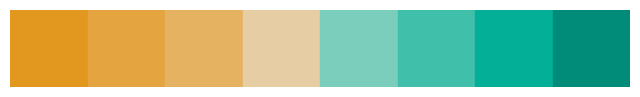

In [9]:
for region in ["intra"]:
    palette=["#E2971F","#E4A541","#E5B262","#e7cda4","#7BCEBC","#40BFAA","#04AF98","#008C79"]
     # Example data
    data = [-1.7,-0.1,1.4,1.5,2.3,2.7]
    
    fig, ax = plt.subplots(figsize=(len(palette), 1))
    for i, color in enumerate(palette):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    
    # Aesthetics
    ax.set_xlim(0, len(palette))
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.savefig(output_dir + '/figures/age_effect_tvalues_intraquad_colormap.pdf', format='pdf')
    plt.show()
